Notes related to the book [Think Bayes v2](https://allendowney.github.io/ThinkBayes2/) which introduces Bayesian statistics using computational methods

In [1]:
# | code-fold: show
# | output: false

# import dependencies

from itertools import product
from typing import Optional

import pandas as pd
import numpy as np
import scipy
from empiricaldist import Pmf, Cdf
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import bambi as bmb
import arviz as az

In [2]:
sns.set_style("whitegrid")

## Bayes' Theorem

::: {.callout-tip title="Theory"}

Given

$$ P(A|B) = \frac{P(A \cap B)}{P(B)} $$

and

$$ P(A \cap B) = P(B \cap A) $$

we can prove Bayes' Theorem:

$$ P(A|B) = \frac{P(A) \cdot P(B|A)}{P(B)} $$

which can be written as

$$ P(H|Obs) = \frac{P(H) \cdot P(Obs|H)}{P(Obs)} $$

where:

\begin{align}
    P(H|Obs) & : \text{Posterior} \\
    P(H) & : \text{Prior} \\
    P(Obs|H) & : \text{Likelihood} \\
    P(Obs) & : \text{Total probability of observation}
\end{align}

___

Usually, to compute the posterior with the grid method, we specify the prior so that it includes all possible values of $H$ with null intersection:

$$ P(Obs) = \sum_{i=1}^n P(H_i) \cdot P(Obs | H_i) $$

:::


## Pmf / Cdf

The followings are class implemented in the `empiricaldist` library which extends `pd.Series` class.

- **Pmf:** Probability mass function
- **Cdf:** Cumulative density function

### Creation and usage

In [3]:
# | code-fold: show

# ----------
# Create Pmf

# from sequence
pmf = Pmf.from_seq([1, 0, 0, 1, 1, 1])

# specify range
range_qs = np.linspace(0, 10, 101)
ps = scipy.stats.norm(5, 1).pdf(range_qs)  # normal distribution
pmf = Pmf(ps, range_qs)
pmf.normalize()

# ------------------
# Specific functions

pmf.mean()
pmf.credible_interval(0.9)
pmf.make_cdf()
pmf.idxmax()
pmf.max_prob()


# ----------
# Create Cdf

# from pmf
cdf = pmf.make_cdf()
pmf = cdf.make_pmf()

### Mixture

**TODO**: Add corresponding matrix operations  

We can compute a distribution as mixture of other distributions

In [4]:
# | code-fold: show

def make_mixture(pmf: Pmf, pmf_seq: list[pmf]) -> Pmf:
    """
    Make a mixture of distributions
    
    pmf: map each hypothesis to a probability
    pmf_seq: sequence pmf, for each hypothesis
    """

    df = pd.DataFrame(pmf_seq).fillna(0).transpose()
    df *= np.array(pmf)
    total = df.sum(axis=1)

    return Pmf(total)

:::{.callout-note title="Example"}

We choose a dice at random on a bag and roll it 1 time, we don't know the number of sides, but we know the corresponding probability (e.g. the number of dices on the bag):
\begin{align}
    P(nb\_sides=4) = 1 / 6  \\
    P(nb\_sides=6) = 2 / 6 \\
    P(nb\_sides=8) = 3 / 6 \\
\end{align}

Given this uncertainty, we can compute the Pmf of the outcome

:::

In [5]:
# | code-fold: show
# | tbl-cap: Pmf of distributions mixture

pmf_dice = Pmf([1, 2, 3], [4, 6, 8])
pmf_dice.normalize()

dice_4 = Pmf(1 / 4, range(1, 4 + 1))
dice_6 = Pmf(1 / 6, range(1, 6 + 1))
dice_8 = Pmf(1 / 8, range(1, 8 + 1))

make_mixture(pmf=pmf_dice, pmf_seq=[dice_4,dice_6,dice_8])

,probs
1,0.159722
2,0.159722
3,0.159722
4,0.159722
5,0.118056
6,0.118056
7,0.062500
8,0.062500


### Utils Pmf

In [6]:
# | code-fold: show

def pmf_from_dist(dist, qs: np.array) -> Pmf:
    """
    Make a discrete approximation of a scipy distribution.
    dist: SciPy distribution object
    qs: quantities
    """

    ps = dist.pdf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()

    return pmf


def pmf_kde_from_sample(sample: np.array, qs: np.array, **options) -> Pmf:
    """
    Make a kernel density estimate from a sample

    sample: sequence of values
    qs: quantities where we should evaluate the KDE
    """

    kde = scipy.stats.gaussian_kde(sample)
    ps = kde(qs)
    pmf = Pmf(ps, qs, **options)
    pmf.normalize()

    return pmf


def kde_from_pmf(pmf: Pmf, n: int = 101, qs: Optional[np.array] = None, **options) -> Pmf:
    """
    Make a kernel density estimate from a Pmf.

    pmf: Pmf object
    n: number of points
    """

    if not qs:
        qs = np.linspace(pmf.qs.min(), pmf.qs.max(), n)

    kde = scipy.stats.gaussian_kde(pmf.qs, weights=pmf.ps)
    ps = kde.evaluate(qs)
    pmf = Pmf(ps, qs, **options)
    pmf.normalize()

    return pmf

## Grid Method

Given a prior and likelihood, we can compute the posterior estimation for the entire range of hypotheses.

### 1-Parameter Grid

**Steps:**

(1) Define the prior ($P(H)$).


(2) Define the likelihood ($P(Obs|H)$).


(3) Multiply the prior and likelihood ($P(H) \cdot P(Obs|H)$).


(4) Normalize (divide by $P(Obs) = \sum_{i=1}^n P(H_i) \cdot P(Obs | H_i)$).


(5) Ensure the range of your parameters covers all plausible values.


:::{.callout-note title="Example"}

Throwing a coin 10 times, we observe 3 tails. What is the posterior rate of tails ?

:::


In [7]:
# | code-fold: show
# | output: false

# Define prior
range_qs = np.linspace(0, 1, 101)
pmf_prior = Pmf(1, range_qs)
pmf_prior.normalize()

# Define likelihood
likelihood = scipy.stats.binom.pmf(3, 10, pmf_prior.qs)

# Multiply prior and likelihood
pmf_posterior = pmf_prior * likelihood

# Normalize
pmf_posterior.normalize()

0.09000901079118087

Parameter value:
    - Mean : 0.333
    - 90% Credible interval: [0.14 0.56]
    - Most probable value: 0.3



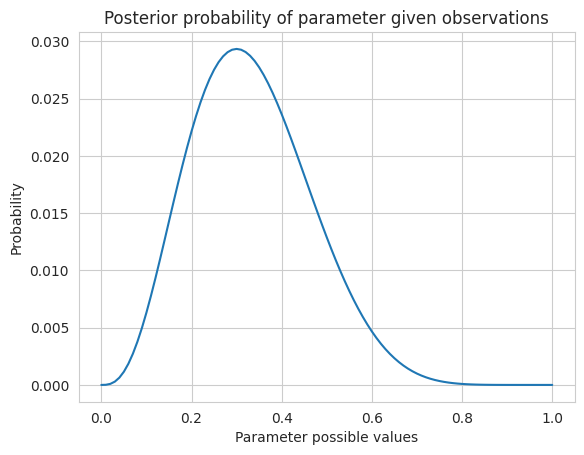

In [8]:
print(f"""Parameter value:
    - Mean : {pmf_posterior.mean():.3f}
    - 90% Credible interval: {pmf_posterior.credible_interval(0.9)}
    - Most probable value: {pmf_posterior.idxmax()}
"""
)

pmf_posterior.plot(
    **{
        "title": "Posterior probability of parameter given observations",
        "xlabel": "Parameter possible values",
        "ylabel": "Probability",
    }
)
plt.show()

### 2-parameters grid

We can use the 1-parameter grid approach with 2 parameters

**Functions:**

In [9]:
# | code-fold: show

def make_joint(pmf1: Pmf, pmf2: Pmf) -> pd.DataFrame:
    """
    Compute the outer product of two Pmfs, usually priors of two parameters.
    Output dataframe: (columns = pmf1.qs / index = pmf2.qs)
    """

    X, Y = np.meshgrid(pmf1, pmf2)
    return pd.DataFrame(X * Y, columns=pmf1.qs, index=pmf2.qs)


def plot_joint(
    joint: pd.DataFrame,
    title: str = "Plot joint",
    xlabel: str = "x",
    ylabel: str = "y",
    cmap: str = "Blues",
    add_contour: bool = True,
) -> None:
    """
    Plot a joint distribution with a color mesh.
    x-axis: joint DataFrame columns
    y-axis: joint DataFrame index
    """

    vmax = joint.to_numpy().max() * 1.1

    plt.pcolormesh(
        joint.columns,
        joint.index,
        joint,
        cmap=cmap,
        vmax=vmax,
        shading="nearest",
    )

    plt.colorbar()

    if add_contour:
        plt.contour(joint.columns, joint.index, joint, linewidths=1.5, cmap="gray_r")

    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)


def joint_to_marginal(joint: pd.DataFrame) -> tuple[Pmf, Pmf]:
    """
    Compute the marginal distribution for a joint distribution
    Outuput tuple:
        - First distribution: marginal of columns
        - Second distribution: marginal of index
    """

    marginal_columns = joint.sum(axis=0)
    marginal_index = joint.sum(axis=1)

    pmf_marginal_columns = Pmf(marginal_columns)
    pmf_marginal_index = Pmf(marginal_index)

    return pmf_marginal_columns, pmf_marginal_index

:::{.callout-note title="Example"}

We draw at random a man and a woman from the population.  
The woman is taller than the man, but we do not know by how much.  

→ Compute the posterior size of each one.  


| Parameter | Man | Woman |
| - | - | - |
| Prior size distribution | Normal $(\mu, \sigma^2) = (178, 7.7)$ | Normal $(\mu, \sigma^2) = (163, 7.3)$ |

:::


In [10]:
# | code-fold: show

# Prior

range_size = np.arange(140, 205, 0.5)
pmf_prior_size_man = Pmf(scipy.stats.norm(178, 7.7).pdf(range_size), range_size + 10)
pmf_prior_size_man.normalize()

pmf_prior_size_woman = Pmf(scipy.stats.norm(163, 7.3).pdf(range_size), range_size)
pmf_prior_size_woman.normalize()

joint_prior_size = make_joint(pmf_prior_size_man, pmf_prior_size_woman)


# Likelihood

# Observed: woman > man
col_vals, index_vals = np.meshgrid(joint_prior_size.columns, joint_prior_size.index)
likelihood = col_vals < index_vals


# Bayes theorem

joint_posterior_size = joint_prior_size * likelihood
joint_posterior_size /= joint_posterior_size.sum().sum()


# Marginal
pmf_posterior_size_man, pmf_posterior_size_woman = joint_to_marginal(joint_posterior_size) 

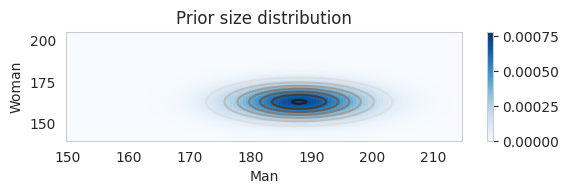

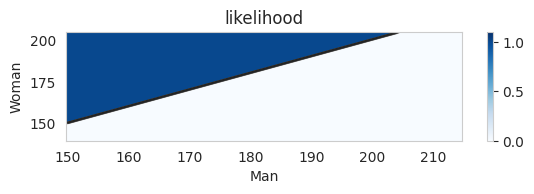

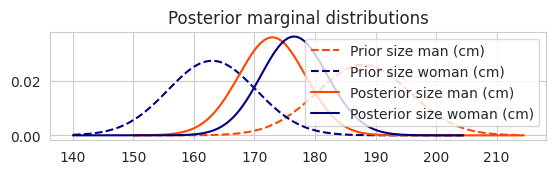

In [11]:
# Plot results

plt.subplot(311)
plot_joint(joint_prior_size, title="Prior size distribution", xlabel="Man", ylabel="Woman")
plt.show()

plt.subplot(312)
plot_joint(
    pd.DataFrame(likelihood, columns=joint_prior_size.columns, index=joint_prior_size.index),
    title="likelihood",
    xlabel="Man",
    ylabel="Woman",
)
plt.show()

plt.subplot(313)
pmf_prior_size_man.plot(label="Prior size man (cm)", linestyle="--", color="orangered")
pmf_prior_size_woman.plot(label="Prior size woman (cm)", linestyle="--", color="navy")
pmf_posterior_size_man.plot(label="Posterior size man (cm)", color="orangered")
pmf_posterior_size_woman.plot(label="Posterior size woman (cm)", color="navy")
plt.gca().set(title="Posterior marginal distributions")
plt.legend()
plt.show()

## Probability Laws

The following section introduces several probability laws and their usage in Bayesian statistics.

### Binomial

::: {.callout-tip title="Theory"}

Given $n$ independent Bernoulli trials with a given conversion rate $p$, the number of successes is described by the binomial law:

$$ X \sim B(n,p) \implies P(X=k) = \binom{n}{k} p^{k} (1-p)^{n-k} $$

:::

#### Estimating Proportion $p$

##### Grid Method

:::{.callout-note title="Example"}

We flip a coin 10 times and get 3 tails. What is the probability of a tail?

:::


In [12]:
# | code-fold: show
# | output: false


nb_conversion, nb_trials = 3, 10

# Prior
range_qs = np.linspace(0, 1, 101)
pmf_prior = Pmf(1, range_qs)
pmf_prior.normalize()

# Likelihood
likelihood = scipy.stats.binom.pmf(nb_conversion, nb_trials, pmf_prior.qs)  # binom.pmf(k, n, p)

# Bayes formula
pmf_posterior = pmf_prior * likelihood
pmf_posterior.normalize()

0.09000901079118087

##### Conjugate Priors

::: {.callout-tip title="Theory"}

The Beta distribution is the conjugate prior of the Binomial distribution.

Given:

$$ \text{prior} \sim \text{Beta}(a, b) $$
$$ \text{number of conversions}: k $$
$$ \text{number of trials}: n $$

The posterior can be computed as:

$$ \text{posterior} \sim \text{Beta}(a + k, b + n - k) $$

To get a prior with a uniform distribution between 0 and 1, we can use $a = b = 1$:

$$ U(0, 1) = \text{Beta}(1, 1) $$

:::


In [13]:
# | code-fold: show
# | output: false


nb_conversion, nb_trials = 3, 10
range_qs = np.linspace(0, 1, 101)

pmf_posterior = Pmf(scipy.stats.beta(1 + nb_conversion, 1 + nb_trials - nb_conversion).pdf(range_qs), range_qs)

pmf_posterior.normalize()

100.00001098900192

##### MCMC

In [14]:
# | code-fold: show
# | output: false


nb_conversion, nb_trials = 3, 10


with pm.Model() as model:
    conversion_rates = pm.Uniform("conversion_rates", 0, 1)
    nb_conversion = pm.Binomial("nb_conversion", n=nb_trials, observed=nb_conversion, p=conversion_rates)
    trace_binom = pm.sample(1000, return_inferencedata=False)

posterior_samples = trace_binom.get_values("conversion_rates")

pd.Series(posterior_samples).quantile([0.05, .95]).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rates]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


0.05    0.14
0.95    0.56
dtype: float64

#### Estimating Count

:::{.callout-note title="Example"}

On an audience of 0 to 2000 peoplen we ask for the number of people born on the following dates:

| Date | Number of Births |
| - | - |
| 11th of May | 2 |
| 23rd of May | 1 |
| 1st of August | 0 |

→ How many people are there?

:::

In [15]:
# | code-fold: show
# | output: false

# Prior
range_qs = np.arange(0, 2000)
pmf_prior = Pmf(1, range_qs)
pmf_prior.normalize()

# Likelihood
likelihood = np.ones(len(pmf_prior))


for nb_conversion in [2, 1, 0]:
    likelihood *= scipy.stats.binom.pmf(nb_conversion, pmf_prior.qs, 1 / 365)

# Bayes formula
pmf_posterior = pmf_prior * likelihood
pmf_posterior.normalize()

0.006758809792207891

### Multinomial

Modelize n independant trials with k possible outcomes at each trials, with a given probability for each outcome

:::{.callout-note title="Example"}


Can be used in mark and recapture problem:

* A reviewer detects 20 errors errors on a coding's review
* A second reviewer detects 15 errors, among which 3 errors were detected by the first reviewer
* Given that each reviewer has a probability p1, p2 of detecting an error, every error fall into one of those categories:


$$ P(\bar{R_1} \cap \bar{R_2}) = (1 - p_1) * (1 - p_2) $$
$$ P(\bar{R_1} \cap R_2) = (1 - p_1) * p_2 $$
$$ P(R_1 \cap \bar{R_2}) = p_1 * (1 - p_2) $$
$$ P(R_1 \cap R_2) = p_1 * p_2 $$

:::


In [16]:
# | code-fold: show
# | output: false


# Priors
range_p = np.linspace(0, 1, 51)
range_nb_errors = np.arange(32, 350, 5)

cols = ["p1", "p2", "nb_e"]

prior = pd.DataFrame(list(product(range_p, range_p, range_nb_errors)), columns=cols)
prior["p"] = 1 / len(prior)

prior = Pmf(prior.set_index(cols).p)

# Likelihood

k10 = 20 - 3  # nb seen by first reviewer only
k01 = 15 - 3  # nb seen by second reviewer only
k11 = 3  # nb seen by both reviewers


likelihoods = prior.copy()

for p1, p2, nb_e in prior.index:
    k00 = nb_e - (k10 + k01 + k11)

    obs = [k00, k10, k01, k11]
    probs = [
        (1 - p1) * (1 - p2),  # prob k00
        p1 * (1 - p2),        # prob k10
        (1 - p1) * p2,        # prob k01
        p1 * p2,              # prob k11
    ]

    likelihood = scipy.stats.multinomial.pmf(obs, nb_e, probs)

    likelihoods[p1, p2, nb_e] = likelihood

# Bayes formula 
posterior = prior * likelihoods
posterior.normalize()

# Marginal 
marginal_nb_e = Pmf(posterior.rename("p").reset_index().groupby("nb_e").p.sum())

### Poisson

::: {.callout-tip title="Theory"}

Given the following conditions:

| Condition | Description |
| - | - |
| Event frequency | An event occurs at frequency $\lambda$ over a given period |
| Uniform probability | The chance of occurring is uniform over a given period |
| Independence | The occurrence of an event does not impact the occurrence of other events |

The number of events that occurred over a given period follows a Poisson distribution:

$$ P(X=k) = \frac{\lambda^k \cdot e^{-\lambda}}{k!} $$

:::


:::{.callout-note title="Example"}

Suppose we can model the number of goals of a football team by a Poisson process. Our prior follows a Gamma distribution with parameter 1.4.  

→ Compute the posterior distribution of $\lambda$ if a team scores 4 goals.

:::


#### Grid method

In [17]:
# | code-fold: show
# | output: false

nb_events_obs = 4

# Prior
range_qs = np.linspace(0, 10, 101)
pmf_prior = Pmf(scipy.stats.gamma(1.4).pdf(range_qs), range_qs)
pmf_prior.normalize()

# Likelihood
likelihood = scipy.stats.poisson(pmf_prior.qs).pmf(nb_events_obs)

# Bayes formula
pmf_posterior = pmf_prior * likelihood
pmf_posterior.normalize()

0.05015532557804499

#### Conjugate Priors

::: {.callout-tip title="Theory"}

The Gamma distribution is the conjugate prior of the Poisson distribution.

Given:

| Parameter | Description |
| - | - |
| Prior | $\text{prior} \sim \text{Gamma}(\alpha, \beta)$ |
| Number of events | $k$ |
| Duration | $t$ |

The posterior can be computed as:

$$ \text{posterior} \sim \text{Gamma}(\alpha + k, \beta + t) $$

:::


In [18]:
# | code-fold: show
# | output: false

alpha, beta = 1.4, 1
obs_k, obs_t = 4, 1

alpha_updated, beta_updated = alpha + obs_k, (beta + obs_t)

gamma_dist = scipy.stats.gamma(alpha_updated, scale=1 / beta_updated) # scale factor equal to 1 / b
                               
range_qs = np.linspace(0, 10, 101)
pmf_posterior_conjugate = Pmf(gamma_dist.pdf(range_qs), range_qs)
pmf_posterior_conjugate.normalize()

9.999714447234826

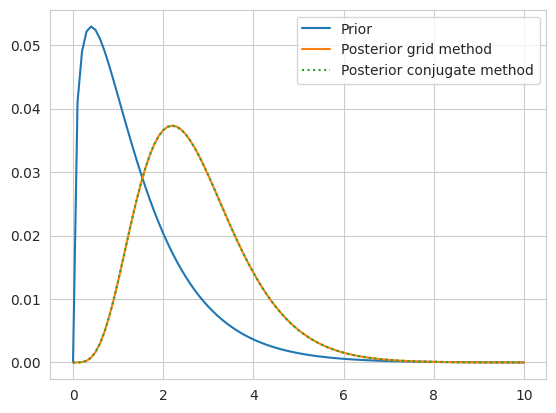

In [19]:
pmf_prior.plot(label="Prior")
pmf_posterior.plot(label="Posterior grid method")
pmf_posterior_conjugate.plot(label='Posterior conjugate method', linestyle="dotted")

plt.legend()
plt.title = "Distribution of lambda"
plt.xlabel = "Lambda"
plt.ylabel = "Probability"

plt.show()

#### MCMC

In [20]:
# | code-fold: show
# | output: false

obs_k = 4

with pm.Model() as model:
    lam = pm.Gamma("lambda", alpha=1.4, beta=1)
    nb_events = pm.Poisson("nb_event", mu=lam, observed=obs_k)
    trace = pm.sample(1000, return_inferencedata=False)

posterior_samples = trace.get_values("lambda")

pd.Series(posterior_samples).quantile([0.05, .95]).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


0.05    1.07
0.95    4.93
dtype: float64

### Exponential

::: {.callout-tip title="Theory"}

Given the hypotheses of the Poisson distribution, the distribution of the duration until the next event follows an exponential distribution:

$$ P(X=t) = \lambda \cdot e^{-\lambda t} $$

:::


:::{.callout-note title="Example"}

Suppose we can model the number of goals of a football team by a Poisson process. Our prior follows a Gamma distribution with parameter 1.4.  

→ Compute the posterior distribution of $\lambda$ if a team scores goals at the 11th and 23rd minutes.

:::


#### Grid method

In [21]:
# | code-fold: show
# | output: false

elapsed_time_1 = 11 / 90
elapsed_time_2 = (23 - 11) / 90

# Prior: range of lambda
range_qs = np.linspace(0, 10, 101)
pmf_prior = Pmf(scipy.stats.gamma(1.4).pdf(range_qs), range_qs)
pmf_prior.normalize()


# Likelihood
lams = range_qs
likelihood_1 = lams * np.exp(-lams * elapsed_time_1)
likelihood_2 = lams * np.exp(-lams * elapsed_time_2)

# Bayes formula
pmf_posterior = pmf_prior * likelihood_1 * likelihood_2
pmf_posterior.normalize()

1.566293892166005

### Normal

The aim is usually to estimate the parameters $(\mu, \sigma^2)$ of the normal distribution.


:::{.callout-note title="Example"}

We compare the results of a given value across a control and a test group. We assume the results follow a normal distribution.  

→ We want to know if the difference in means between the groups is significant.

:::


#### Grid method

In [22]:
# | code-fold: show
# | output: false


control_obs = [24, 43, 58, 71, 43, 49, 61, 44, 67, 49, 53, 56, 59, 52, 62, 54, 57, 33, 46, 43, 57]
test_obs = [42, 43, 55, 26, 62, 37, 33, 41, 19, 54, 20, 85, 46, 10, 17, 60, 53, 42, 37, 42, 55, 28, 48]


# Define priors

range_mu = np.linspace(30, 60, 201)
pmf_prior_mu = Pmf(1, range_mu)
pmf_prior_mu.normalize()

range_sigma = np.linspace(7, 30, 201)
pmf_prior_sigma = Pmf(1, range_sigma)
pmf_prior_sigma.normalize()

prior_joint = make_joint(pmf_prior_mu, pmf_prior_sigma)


# Likelihood

# Control group
mu_mesh, sigma_mesh, obs_mesh = np.meshgrid(pmf_prior_mu.qs, pmf_prior_sigma.qs, control_obs)
likelihood_control = scipy.stats.norm(mu_mesh, sigma_mesh).pdf(obs_mesh)
likelihood_control = likelihood_control.prod(axis=-1)

# Test group
mu_mesh, sigma_mesh, obs_mesh = np.meshgrid(pmf_prior_mu.qs, pmf_prior_sigma.qs, test_obs)
likelihood_test = scipy.stats.norm(mu_mesh, sigma_mesh).pdf(obs_mesh)
likelihood_test = likelihood_test.prod(axis=-1)


# Bayes formula
posterior_joint_control = prior_joint * likelihood_control
posterior_joint_control /= posterior_joint_control.sum().sum()

posterior_joint_test = prior_joint * likelihood_test
posterior_joint_test /= posterior_joint_test.sum().sum()


# Marginal
pmf_posterior_mu_control, pmf_posterior_sigma_control = joint_to_marginal(posterior_joint_control)
pmf_posterior_mu_test, pmf_posterior_sigma_test = joint_to_marginal(posterior_joint_test)

# Diff of mu
posterior_mu_diff = pmf_posterior_mu_control.sub_dist(pmf_posterior_mu_test)
posterior_mu_diff = kde_from_pmf(posterior_mu_diff)

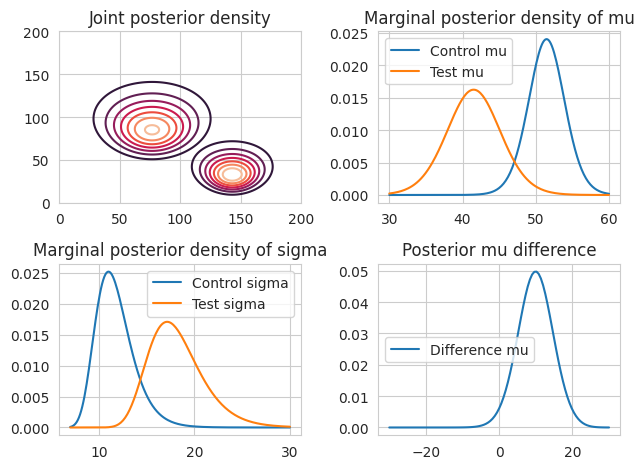

In [23]:
plt.subplot(221)
plt.contour(posterior_joint_control)
plt.contour(posterior_joint_test)
plt.gca().set(title="Joint posterior density")

plt.subplot(222)
pmf_posterior_mu_control.plot(label="Control mu")
pmf_posterior_mu_test.plot(label="Test mu")
plt.legend()
plt.gca().set(title="Marginal posterior density of mu")

plt.subplot(223)
pmf_posterior_sigma_control.plot(label="Control sigma")
pmf_posterior_sigma_test.plot(label="Test sigma")
plt.legend()
plt.gca().set(title="Marginal posterior density of sigma")

plt.subplot(224)
posterior_mu_diff.plot(label="Difference mu")
plt.legend()
plt.gca().set(title="Posterior mu difference")


plt.tight_layout()

plt.show()

#### MCMC

In [24]:
# | code-fold: show
# | output: false

with pm.Model() as model:
    mu = pm.Uniform("mu", 30, 60)
    sigma = pm.Uniform("sigma", 7, 30)
    result = pm.Normal("result", mu=mu, sigma=sigma, observed=control_obs)
    trace_binom = pm.sample(1000, return_inferencedata=False)

posterior_samples = trace_binom.get_values("mu")

pd.Series(posterior_samples).quantile([0.05, .95]).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


0.05    47.20
0.95    55.78
dtype: float64

### Weibull

The Weibull distribution is used in survival analysis to predict the time until an event (e.g., death).
Here, we will use the `weibull_min` implementation of SciPy. Given parameters $\lambda$ and $k$, its probability density function (PDF) describes the time until an event.

#### Parameters' Influence

| Parameter | Description |
| - | - |
| $\lambda$ | Mean of lifetime |
| $k$ | Shape |


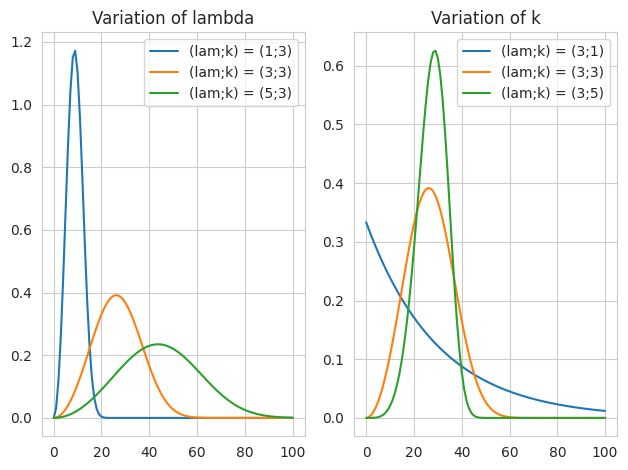

In [25]:
range_wb = np.linspace(0, 10, 101)

fig, axs = plt.subplots(nrows=1, ncols=2)

for lam in [1, 3, 5]:
    for k in [3]:
        sns.lineplot(scipy.stats.weibull_min(c=k, scale=lam).pdf(range_wb), label=f"(lam;k) = ({lam};{k})", ax=axs[0])

for lam in [3]:
    for k in [1, 3, 5]:
        sns.lineplot(scipy.stats.weibull_min(c=k, scale=lam).pdf(range_wb), label=f"(lam;k) = ({lam};{k})", ax=axs[1])


axs[0].title.set_text('Variation of lambda')
axs[1].title.set_text('Variation of k')

plt.tight_layout()
plt.show()

:::{.callout-note title="Example"}

We stop an experiment 8 years after its beginning.  
Some subjects arrived during the experiment, some died, and some survived.  
Suppose we can model their lifetime using the Weibull distribution.  
→ Compute the distribution of $k$ and $\lambda$.

:::


In [26]:
# Generate distribution and observations

np.random.seed(1)

# Distribution
k, lam = 0.8, 3
actual_dist = scipy.stats.weibull_min(c=k, scale=lam)


# Observations
obs_time = 8
nb_obs = 20

start = np.random.uniform(0, 8, size=nb_obs)
duration = actual_dist.rvs(size=nb_obs, random_state=42)

df_obs = pd.DataFrame({"start": start,"duration": duration,}).round(2)
df_obs["end"] = df_obs["start"] + df_obs["duration"]

df_obs["censored"] = df_obs["end"] > obs_time
df_obs["obs_t"] = df_obs["end"].clip(upper=8) - df_obs["start"]

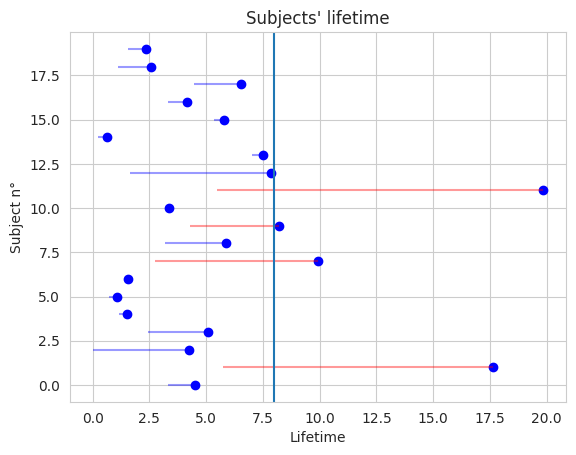

In [27]:
plt.hlines(
    y=df_obs.index,
    xmin=df_obs.start,
    xmax=df_obs.end,
    color=df_obs.censored.apply(lambda c: 'blue' if not c else "red"),
    alpha=0.4)

plt.scatter(df_obs.end, df_obs.index, color='blue')
plt.axvline(x=obs_time)
plt.gca().set(title="Subjects' lifetime", xlabel="Lifetime", ylabel="Subject n°")
plt.show()

In [28]:
#| tbl-cap: Example of subject's data

df_obs.head()

,start,duration,end,censored,obs_t
0,3.34,1.17,4.51,False,1.17
1,5.76,11.89,17.65,True,2.24
2,0.00,4.23,4.23,False,4.23
3,2.42,2.68,5.10,False,2.68
4,1.17,0.33,1.50,False,0.33


#### Grid method

In [29]:
# | code-fold: show
# | output: false


# Define priors
range_k = np.linspace(0.1, 2, 101)
pmf_prior_k = Pmf(1, range_k)
pmf_prior_k.normalize()

range_lam = np.linspace(0.1, 6, 101)
pmf_prior_lam = Pmf(1, range_lam)
pmf_prior_lam.normalize()

joint_prior = make_joint(pmf_prior_k, pmf_prior_lam)

# Likelihood

k_mesh, lam_mesh, time_mesh = np.meshgrid(range_k, range_lam, df_obs[~df_obs.censored].obs_t)
likelihood_uncensored = scipy.stats.weibull_min(c=k_mesh, scale=lam_mesh).pdf(time_mesh)
likelihood_uncensored = likelihood_uncensored.prod(axis=-1)

k_mesh, lam_mesh, time_mesh = np.meshgrid(range_k, range_lam, df_obs[df_obs.censored].obs_t)
likelihood_censored = scipy.stats.weibull_min(c=k_mesh, scale=lam_mesh).sf(time_mesh)
likelihood_censored = likelihood_censored.prod(axis=-1)


# Bayes formula
joint_posterior = joint_prior * likelihood_uncensored * likelihood_censored
joint_posterior /= joint_posterior.sum().sum()


# Marginal
posterior_k, posterior_lam = joint_to_marginal(joint_posterior)

**TODO:**

* Add MCMC with censor and uncensored data
* Add Hypergeometric distribution

## Regression

### Logistic Regression

::: {.callout-tip title="Theory"}


To demonstrate the logistic regression formula, we can use the following:

$$ O(H|obs) = O(H) * \frac{P(Obs|H)}{P(Obs|\bar{H})} $$

$$
O(x) = \frac{P(x)}{1 - P(x)}
$$

If observations are independent, then

$$
O(H|obs^n) = O(H) * (\frac{P(Obs|H)}{P(Obs|\bar{H})})^n 
$$

$$
\implies log(O(H|obs^n)) = log(O(H)) + n *log(\frac{P(Obs|H)}{P(Obs|\bar{H})})
$$

$$
\implies O(H|obs^n) = e^{log(O(H)) + n *log(\frac{P(Obs|H)}{P(Obs|\bar{H})})}
$$

$$
\implies O(H|obs^n) = e^{a * x + b}
$$

$$
\implies P(H|obs^n) = \frac{1}{1 + e^{-(a*x+b)}}
$$

With:  
$$ a =log (\frac{P(Obs|H)}{P(Obs|\bar{H})}): Log \: likelihood \:ratio $$
$$ b = log(O(H)): prior $$

:::

The aim is to define the values of $a$ and $b$.

#### Grid method

:::{.callout-note title="Example"}

We examine the risk of accidents given the temperature.
We assume this can be modeled by a logistic regression.  

In the following, we have:

| Parameter | Description |
| - | - |
| $a$ | Slope |
| $b$ | Intercept |

:::


In [30]:
temp = [66, 70, 69, 68, 67, 72, 73, 70, 57, 63, 70, 78, 67, 53, 67, 75, 70, 81, 76, 79, 75, 76, 58]
converted = [0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1]

df = pd.DataFrame({"temp": temp, "conv": converted})

# Normalize data
offset = df["temp"].mean()
df["x"] = df["temp"] - offset
df["y"] = df["conv"]

In [31]:
# | code-fold: show
# | output: false


# Priors
range_a = np.linspace(-0.8, 0.1, 51)
range_b = np.linspace(-5, 1, 51)

cols = ["a", "b"]

prior = pd.DataFrame(list(product(range_a, range_b)), columns=cols)
prior["p"] = 1 / len(prior)

prior = Pmf(prior.set_index(cols).p)


# Likelihood
likelihood = prior.copy()

for a, b in prior.index:
    likelihoods_converted = scipy.special.expit(a * df[df.y == 1].x + b)
    likelihoods_not_converted = 1 - scipy.special.expit((a * df[df.y == 0].x + b))

    likelihood[a, b] = likelihoods_converted.prod() * likelihoods_not_converted.prod()


# Bayes formula
posterior = prior * likelihood
posterior /= posterior.sum()

# Posterior marginal
posterior_a = Pmf(posterior.rename("p").reset_index().groupby("a").p.sum())
posterior_b = Pmf(posterior.rename("p").reset_index().groupby("b").p.sum())

#### MCMC - PyMC

In [32]:
# | code-fold: show
# | output: false

with pm.Model() as model:
    a = pm.Uniform("a", -0.8, 0.1)
    b = pm.Uniform("b", -5, 1)
    
    est_expit = 1 / (1 + np.exp(- (a * df.x + b)))
    bernouilli = pm.Bernoulli('trials', p=est_expit, observed=df.y)
    
    trace_binom = pm.sample(1000, return_inferencedata=False)

a_posterior_samples = trace_binom.get_values("a")
b_posterior_samples = trace_binom.get_values("b")

posterior_samples =pd.DataFrame({"a": a_posterior_samples, "b":b_posterior_samples})
posterior_samples.mean().round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


a   -0.30
b   -1.25
dtype: float64

#### MCMC - Bambi

In [33]:
# | code-fold: show
# | output: false

model = bmb.Model("y ~ x", df, family="bernoulli")
fitted = model.fit()

Modeling the probability that y==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [34]:
az.summary(fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.148,0.580,-2.231,-0.070,0.012,0.009,2266.0,1914.0,1.0
x,-0.253,0.111,-0.464,-0.057,0.002,0.002,3071.0,2405.0,1.0


#### Interpretation

##### Interpretation of Intercept

We can use the posterior distribution of the intercept to get the probability when $x = 0$:

$$ b = \log(O(H)) \implies P(H) = \frac{1}{1 + e^{-b}} $$


In [35]:
# | code-fold: show
# | output: false

qs = posterior_b.qs
ps = posterior_b.ps


pmf_at_0 = Pmf(ps, scipy.special.expit(qs))

# identical as :
pmf_at_0 = posterior_b.transform(scipy.special.expit)

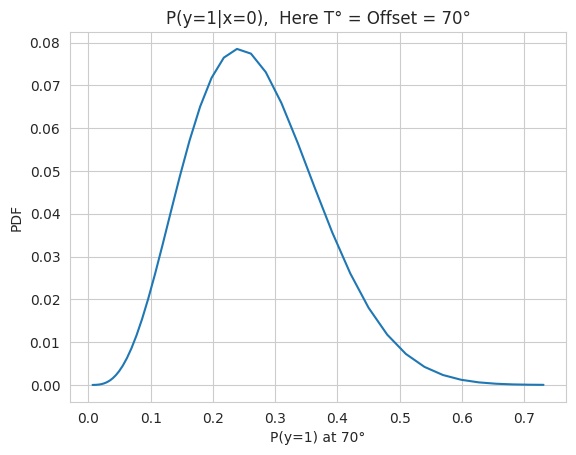

In [36]:
pmf_at_0.plot()
plt.gca().set(title="P(y=1|x=0),  Here T° = Offset = 70°", xlabel="P(y=1) at 70°", ylabel="PDF")
plt.show()

##### Interpretation of Slope

The distribution of $a$ gives us the log likelihood ratio:

$$ a = \log \left( \frac{P(Obs|H)}{P(Obs|\bar{H})} \right) \implies \text{likelihood ratio} = \frac{P(Obs|H)}{P(Obs|\bar{H})} = e^a $$


In [37]:
# | code-fold: show
# | output: false

ps = posterior_a.ps
qs = posterior_a.qs

pmf_likelihood_ratio = Pmf(ps, np.exp(qs))

# identical as:
pmf_likelihood_ratio = posterior_a.transform(np.exp)

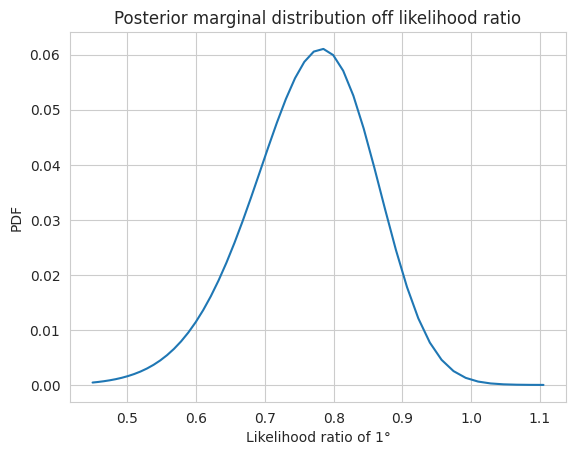

In [38]:
pmf_likelihood_ratio.plot()
plt.gca().set(title="Posterior marginal distribution off likelihood ratio", xlabel="Likelihood ratio of 1°", ylabel="PDF")
plt.show()

##### Uncertainty on Logistic Curve

By leveraging simulations on posteriors, we can define credible intervals for our logistic regression:  

* For each value of $x$:
   - Compute probabilities by sampling from the posterior distribution of $a$ and $b$.
   - Compute the related credible interval.


In [39]:
# | code-fold: show
# | output: false

# Simulation parameters
RANGE_T = np.linspace(30, 85, 101)
RANGE_X = RANGE_T - offset

NB_SAMPLE_PER_X = 10_000
QUANTS = [0.05, 0.5, 0.95]

x_to_probs_thresh = {} # Will contain the q5, q50 and q95 of the distribution of probs for each x


# For each value of x
for x in RANGE_X:

    # compute n probs by sampling from posteriors
    log_odds = posterior_a.choice(NB_SAMPLE_PER_X) * x + posterior_b.choice(NB_SAMPLE_PER_X) 
    probs = scipy.special.expit(log_odds)
    x_to_probs_thresh[x] = pd.Series(probs).quantile(QUANTS)

# Format the data
x_to_probs_thresh = pd.DataFrame(x_to_probs_thresh).T.rename_axis("x").reset_index()
x_to_probs_thresh["temp"] = RANGE_T

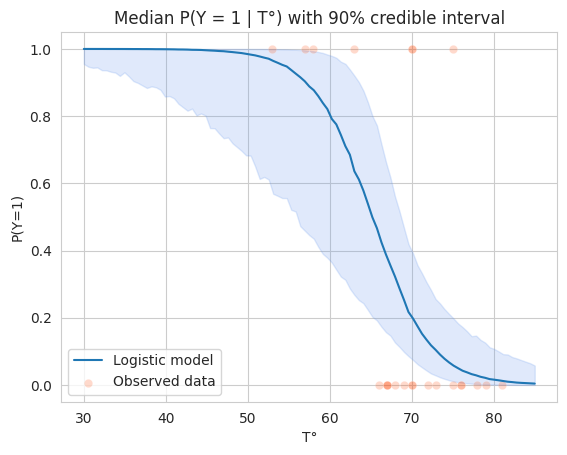

In [40]:
plt.fill_between(
    x_to_probs_thresh["temp"],
    x_to_probs_thresh[0.05],
    x_to_probs_thresh[0.95],
    color="cornflowerblue",
    alpha=0.2,
)

sns.lineplot(data=x_to_probs_thresh, x="temp", y=0.5, label="Logistic model")
sns.scatterplot(
    data=df, x="temp", y="y", alpha=0.2, color="orangered", label="Observed data"
)

plt.gca().set(
    title="Median P(Y = 1 | T°) with 90% credible interval",
    xlabel="T°",
    ylabel="P(Y=1)",
)
plt.show()

### Linear Regression

::: {.callout-tip title="Theory"}

The assumption of linear regression is that you can model $y$ in the following way:

$$ y = \left(\sum_{i=1}^{n} w_i \cdot x_i\right) + \epsilon $$

With:

$$\epsilon \sim \mathcal{N}(0,\,\sigma^{2})  $$


:::

The aim is to estimate the values of $w_i$ and $\sigma$

#### Grid method

:::{.callout-note title="Example"}

We observe the quantity of snow each year for 54 years. Does the snow quantity tend to increase?

The following notation is used:

$$ y = a \cdot x + b + \mathcal{N}(0, \sigma^2) $$

:::


In [41]:
year = [1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
amount_fall = [28.6, 44.7, 99.2, 66.8, 54.6, 68.7, 12.5, 46.5, 61.9, 57.7, 65.5, 100.6, 34.4, 27.7, 54.2, 64.1, 50.2, 56.3, 49.7, 38.3, 89.3, 53.5, 38.5, 52.5, 30.7, 39.0, 80.1, 88.7, 46.0, 124.2, 77.1, 24.1, 56.6, 43.7, 90.8, 61.5, 112.0, 51.8, 110.7, 40.6, 54.2, 59.1, 85.8, 57.6, 82.3, 31.1, 99.1, 80.6, 141.1, 64.0, 68.0, 90.4, 59.6, 12.2]

df_snow = pd.DataFrame({"year": year, "amount_fall": amount_fall})

offset = df_snow.year.mean()
df_snow["x"] = df_snow.year - offset
df_snow["y"] = df_snow.amount_fall

In [42]:
# | code-fold: show
# | output: false


# Priors

range_a = np.linspace(-0.5, 1.5, 51)
range_b = np.linspace(54, 75, 21)
range_sigma = np.linspace(20, 35, 31)  # epsilon sigma

cols = ["a", "b", "sigma"]

prior = pd.DataFrame(list(product(range_a, range_b, range_sigma)), columns=cols)
prior["p"] = 1 / len(prior)

prior = Pmf(prior.set_index(cols).p)


# Likelihood

likelihood = prior.copy()

for a, b, sigma in prior.index:

    #likelihood = scipy.stats.multinomial.pmf(obs, nb_e, probs)
    
    y_est = a * df_snow.x + b
    residuals = df_snow.y - y_est
    likelihoods = scipy.stats.norm(0, sigma).pdf(residuals)

    likelihood[a, b, sigma] = likelihoods.prod()


# Bayes formula

posterior = prior * likelihood
posterior.normalize()


# Marginal

marginal_a = Pmf(posterior.rename("p").reset_index().groupby("a").p.sum())
marginal_b = Pmf(posterior.rename("p").reset_index().groupby("b").p.sum())
marginal_sigma = Pmf(posterior.rename("p").reset_index().groupby("sigma").p.sum())

#### MCMC - PyMC

In [43]:
# | code-fold: show
# | output: false

with pm.Model() as model:
    a = pm.Uniform("a", -0.5, 1.5)
    b = pm.Uniform("b", 54, 75)
    sigma = pm.Uniform("sigma", 20, 35)

    est_y = a * df_snow.x + b
    y = pm.Normal("y", mu=y_est, sigma=sigma, observed=df_snow.y)
    trace_binom = pm.sample(1000, return_inferencedata=False)

a_posterior_samples = trace_binom.get_values("a")
b_posterior_samples = trace_binom.get_values("b")
sigma_posterior_samples = trace_binom.get_values("sigma")

posterior_samples = pd.DataFrame(
    {
        "a": a_posterior_samples,
        "b": b_posterior_samples,
        "sigma": sigma_posterior_samples,
    }
)
posterior_samples.mean().round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


a         0.49
b        64.47
sigma    32.22
dtype: float64

#### MCMC - Bambi

In [44]:
# | code-fold: show
# | output: false

model = bmb.Model("y ~ x", df_snow)
fitted = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [45]:
az.summary(fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,62.598,3.714,55.817,69.700,0.055,0.039,4623.0,2644.0,1.0
x,0.422,0.236,-0.023,0.864,0.003,0.003,5630.0,2787.0,1.0
y_sigma,27.190,2.632,22.325,32.069,0.038,0.027,4675.0,2799.0,1.0


#### Uncertainty on Regression Curve

By leveraging simulations on posteriors, we can define credible intervals for our linear regression:

* For each value of $x$:
   - Sample from the posterior distribution of $a$, $b$, and $\sigma$.
   - Compute the related credible interval.


In [46]:
# | code-fold: show
# | output: false

# Simulation parameters
RANGE_YEAR = np.linspace(df_snow.year.min(), df_snow.year.max(), 101)
RANGE_X = RANGE_YEAR - offset

NB_SAMPLE_PER_X = 10_000
QUANTS = [0.05, 0.5, 0.95]

x_to_y_thresh = {} # Will contain the q5, q50 and q95 of the distribution of probs for each x

# For each value of x
for x in RANGE_X:
    
    samples_a = marginal_a.choice(NB_SAMPLE_PER_X) 
    samples_b = marginal_b.choice(NB_SAMPLE_PER_X)
    samples_sigma = marginal_sigma.choice(NB_SAMPLE_PER_X)

    # compute n probs by sampling from posteriors
    ys = samples_a * x + samples_b + scipy.stats.norm(0, samples_sigma).rvs(NB_SAMPLE_PER_X) 
    x_to_y_thresh[x] = pd.Series(ys).quantile(QUANTS)

# Format the data
x_to_y_thresh = pd.DataFrame(x_to_y_thresh).T.rename_axis("x").reset_index()
x_to_y_thresh["year"] = RANGE_YEAR

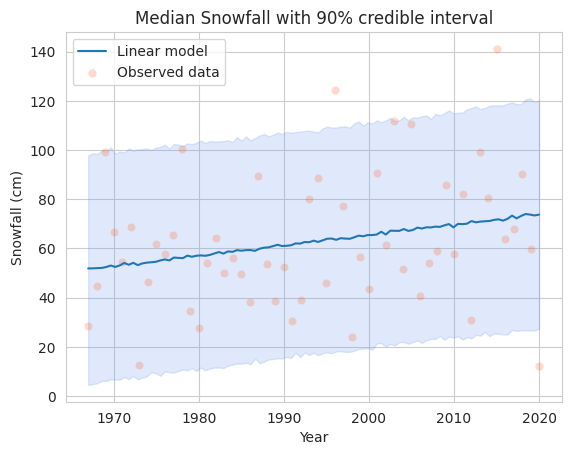

In [47]:
plt.fill_between(
    x_to_y_thresh["year"],
    x_to_y_thresh[0.05],
    x_to_y_thresh[0.95],
    color="cornflowerblue",
    alpha=0.2,
)

sns.lineplot(data=x_to_y_thresh, x="year", y=0.5, label="Linear model")
sns.scatterplot(
    data=df_snow, x="year", y="y", alpha=0.2, color="orangered", label="Observed data"
)

plt.gca().set(
    title="Median Snowfall with 90% credible interval",
    xlabel="Year",
    ylabel="Snowfall (cm)",
)
plt.show()